

# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

Importamos las librerias necesarias

In [15]:
import findspark
findspark.init()
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType, DateType, BooleanType, TimestampType
from google.colab import drive
drive.mount('/content/drive')
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

Incluimos la ruta donde se encuentra el fichero

In [17]:
DATAPATH = os.path.join('content', 'drive', 'My Drive', 'Data') 
filepath = os.path.join(DATAPATH, 'bank-full.csv')
print(filepath)

content/drive/My Drive/Data/bank-full.csv




## Lectura de datos

Leemos el fichero, y ponemos como separador el ;, ademas indicamos que nos saque las nombres de las columnas

In [19]:
bank = spark.read.csv('file:///' + filepath, sep=';', header=True, inferSchema=True)
bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar| married| 

Mostramos el tipo de datos de cada columna

In [20]:
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



In [21]:
bank.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

Contamos el numero de resgistros y columnas

In [22]:
print("1. Número de registros: ", bank.count())
print("2. Número de columnas: ", len(bank.columns))

1. Número de registros:  45211
2. Número de columnas:  20


In [23]:
n=bank.count(),len(bank.columns)
print(n)


(45211, 20)


Ahora vamos a aplicar las buenas prácticas sobre los nombres de las columnas, aunque a simple vista son todas correctas, pero por si acaso, reemplazamos blancos y . y ponemos en minúsculas


In [0]:
for col in bank.columns:
    bank_df = bank.withColumnRenamed(col, col.lower().replace(' ','_').replace('.',''))

In [0]:
bank_df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

Analizamos los posibles valores de cada columna, e indicamos el numero de ocurrencias de cada uno de ellos, para su revisión 

In [25]:
for column in bank_df.columns:
    bank_valores = bank_df.groupby(column).agg(F.count(column).alias("cont_reg")).sort("cont_reg", ascending = False)
    bank_valores.show()

+---+--------+
|age|cont_reg|
+---+--------+
| 32|    2085|
| 31|    1996|
| 33|    1972|
| 34|    1930|
| 35|    1894|
| 36|    1806|
| 30|    1757|
| 37|    1696|
| 39|    1487|
| 38|    1466|
| 40|    1355|
| 41|    1291|
| 42|    1242|
| 45|    1216|
| 29|    1185|
| 46|    1175|
| 43|    1161|
| 44|    1136|
| 47|    1088|
| 28|    1038|
+---+--------+
only showing top 20 rows

+-------------+--------+
|          job|cont_reg|
+-------------+--------+
|  blue-collar|    9732|
|   management|    9458|
|   technician|    7597|
|       admin.|    5171|
|     services|    4154|
|      retired|    2264|
|self-employed|    1579|
| entrepreneur|    1487|
|   unemployed|    1303|
|    housemaid|    1240|
|      student|     938|
|      unknown|     288|
+-------------+--------+

+--------+--------+
| marital|cont_reg|
+--------+--------+
| married|   27214|
|  single|   12790|
|divorced|    5207|
+--------+--------+

+---------+--------+
|education|cont_reg|
+---------+--------+
|secondar

**Conclusión visual de los valores de los atributos**

comprobamos que:
job, education, contact  y  poutcome tienen unknown .


default, housing, loan  y la columna  y son string, pero viendo sus datos podrían ser  boolean.


day + month + year se pueden unir como fecha.


Pickep-up -call tiene dos posibles valores y se concentra casi todo en uno de ellos.


Y vemos que la variable extra_info nos aporta muy poco, ya que la mayoria está sin informar.





default, housing, loan , y : tienen 2 valores y  nos vamos a generar una lista de las variables que consideramos que pueden ser booleanas y actualmente son strings


In [0]:
boolean_columns = ['default', 'housing', 'loan', 'y']

Con estas cuatro variables,  generamos nuevas columnas cuyo nombre termina en _bool y le decimos que son de tipo booleano


In [0]:
for elemento in boolean_columns:
  bank_df = bank_df.withColumn(elemento+'_bool', F.col(elemento).cast('boolean'))

y lo comprobamos de la siguiente manera, vemos que ha transformado los valores a booleanos

In [0]:
bank_df.select('default', 'default_bool', 'housing', 'housing_bool', 'loan', 'loan_bool', 'y', 'y_bool').show()

+-------+------------+-------+------------+----+---------+---+------+
|default|default_bool|housing|housing_bool|loan|loan_bool|  y|y_bool|
+-------+------------+-------+------------+----+---------+---+------+
|     no|       false|    yes|        true|  no|    false| no| false|
|     no|       false|    yes|        true|  no|    false| no| false|
|     no|       false|    yes|        true| yes|     true| no| false|
|     no|       false|    yes|        true|  no|    false| no| false|
|     no|       false|     no|       false|  no|    false| no| false|
|     no|       false|    yes|        true|  no|    false| no| false|
|     no|       false|    yes|        true| yes|     true| no| false|
|    yes|        true|    yes|        true|  no|    false| no| false|
|     no|       false|    yes|        true|  no|    false| no| false|
|     no|       false|    yes|        true|  no|    false| no| false|
|     no|       false|    yes|        true|  no|    false| no| false|
|     no|       fals

Comprobamos que las nuevas variables se han creado correctamente.

In [28]:
bank_df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int'),
 ('default_bool', 'boolean'),
 ('housing_bool', 'boolean'),
 ('loan_bool', 'boolean'),
 ('y_bool', 'boolean')]

Convertimos en fecha la concatenación de day, month & year

In [29]:
date_col = F.concat(F.col("day"), F.lit("/"), F.col("month"),F.lit("/"), F.col("year"))
bank_df = bank_df.withColumn("date", date_col)
bank_df.select("day", "month", "year", "date").show()

+---+-----+----+----------+
|day|month|year|      date|
+---+-----+----+----------+
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
|  5|  may|2008|5/may/2008|
+---+-----+----+----------+
only showing top 20 rows



In [0]:
bank_df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int'),
 ('default_bool', 'boolean'),
 ('housing_bool', 'boolean'),
 ('loan_bool', 'boolean'),
 ('y_bool', 'boolean'),
 ('date', 'string')]

Vemos que la varibles date, sigue siendo string, por lo que la tenemos que pasar a Timestamp.

In [30]:
new_date_col = F.unix_timestamp("date", 'd/MMM/yyyy')
new_date_col = F.to_date(new_date_col.cast(TimestampType()))
bank_df = bank_df.withColumn("datetime_ts", new_date_col)
bank_df.select("date", "datetime_ts").show() 

+----------+-----------+
|      date|datetime_ts|
+----------+-----------+
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
|5/may/2008| 2008-05-05|
+----------+-----------+
only showing top 20 rows



Mostramos otra forma de conertir la fecha
Convertimos el string a Timestamp

In [0]:
bank_df = bank_df.withColumn('now_datetime', 
                                                 F.from_unixtime(F.unix_timestamp(F.col('date'), 'd/MMM/yyyy')))

bank_df.select('date', 'now_datetime').show(10)

+----------+-------------------+
|      date|       now_datetime|
+----------+-------------------+
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
|5/may/2008|2008-05-05 00:00:00|
+----------+-------------------+
only showing top 10 rows



Estudiamos los **registros repetidos**:, estudiaremos  si hay registros que coincidan en todos los campos

Contamos el numero de registros, y el numero de registros diferentes.

En este caso, vemos que son iguales, por lo que **no hay repetidos**

In [31]:

print("··············································")
print("Descripcion                         Volumetría")
print("··············································")
print("1. Número de registros:              ", bank_df.count())
print("2. Número de registros no repetidos: ", bank_df.distinct().count())
print("··············································")

··············································
Descripcion                         Volumetría
··············································
1. Número de registros:               45211
2. Número de registros no repetidos:  45211
··············································


Estudiamos los **nulos** en el dataset



Con estas instrucciones vemos el número de nulos de cada columna

In [32]:
n_rows_bank = bank_df.count()
missing_ops = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / n_rows_bank, 2).alias(c) 
               for c in bank_df.columns]

bank_porc_df=bank_df.select(missing_ops)
bank_porc_df.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+------------+------------+---------+------+----+-----------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|default_bool|housing_bool|loan_bool|y_bool|date|datetime_ts|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+------------+------------+---------+------+----+-----------+
|0.0|0.0|    0.0|      0.0|    0.0|    0.0|    0.0| 0.0|    0.0|0.0|  0.0| 0.0|     0.0|     0.0|  0.0|     0.0|     0.0|0.0|           0.0|     99.83|         0.0|         0.0|      0.0|   0.0| 0.0|        0.0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+-

Hemos extraido el porcentaje de nulos, y como vemos la columna extra_info se puede eliminar ya que tiene un 99.83 % de nulos

In [33]:
bank_df = bank_df.drop('extra_info')
bank_df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- default_bool: boolean (nullable = true)
 |-- housing_bool: boolean (nullable = true)
 |-- loan_bool: boolean (nullable = true)
 |-- y_bool: boolean (nullable = true)
 |-- date: string (nullable = true)
 |-- datetime_ts: date (nullable = true)



Anteriormente, habiamos visto que la variable pdays, en el enunciado nos decia que podía  tener el valor999, y no aparece, pero si vemos que aparece el valor -1 y con un numero elevado de ocurrencias, por lo que vamos a pensar que es un nulo

Comprobamos ordenando en descendente por el pdays, y vemos que el valor 999 no aparece

In [34]:
bank_df.groupby('pdays').agg(F.count('pdays')).sort("pdays", ascending=False).show()

+-----+------------+
|pdays|count(pdays)|
+-----+------------+
|  871|           1|
|  854|           1|
|  850|           1|
|  842|           1|
|  838|           1|
|  831|           1|
|  828|           1|
|  826|           1|
|  808|           1|
|  805|           1|
|  804|           1|
|  792|           2|
|  791|           1|
|  784|           1|
|  782|           1|
|  779|           2|
|  778|           1|
|  776|           1|
|  775|           1|
|  774|           1|
+-----+------------+
only showing top 20 rows



Comprobamos ordenando en ascendente por el pdays, y vemos que el valor -1  es mayoritario

In [35]:
bank_df.groupby('pdays').agg(F.count('pdays')).sort("pdays", ascending=True).show()

+-----+------------+
|pdays|count(pdays)|
+-----+------------+
|   -1|       36954|
|    1|          15|
|    2|          37|
|    3|           1|
|    4|           2|
|    5|          11|
|    6|          10|
|    7|           7|
|    8|          25|
|    9|          12|
|   10|           6|
|   12|           7|
|   13|           6|
|   14|           9|
|   15|           3|
|   17|           4|
|   18|           1|
|   19|           2|
|   20|           2|
|   21|           4|
+-----+------------+
only showing top 20 rows



Sustituimos el valor -1 de pdays por nulos

In [36]:
bank_df = bank_df.withColumn('pdays', 
                     F.when(F.col('pdays') == -1, None).otherwise(F.col('pdays')))
bank_df.groupby("pdays").agg(F.count('pdays').alias("num_reg")).sort("pdays", ascending = True).show()

+-----+-------+
|pdays|num_reg|
+-----+-------+
| null|      0|
|    1|     15|
|    2|     37|
|    3|      1|
|    4|      2|
|    5|     11|
|    6|     10|
|    7|      7|
|    8|     25|
|    9|     12|
|   10|      6|
|   12|      7|
|   13|      6|
|   14|      9|
|   15|      3|
|   17|      4|
|   18|      1|
|   19|      2|
|   20|      2|
|   21|      4|
+-----+-------+
only showing top 20 rows



También vemos que el poutcome, esta en la mayoría de casos sin informar, por lo que entendemos que en la campaña anterior, muchos de los clientes de la base de datos, no participaron

In [37]:
bank_df.groupby("poutcome").agg(F.count('poutcome').alias("num_reg")).sort("poutcome", ascending = False).show()

+--------+-------+
|poutcome|num_reg|
+--------+-------+
| unknown|  36959|
| success|   1511|
|   other|   1840|
| failure|   4901|
+--------+-------+



Comprobamos que la variable "pdays: numero de dias desde que el cliente fue contactado" lo hemos cambiado a nulos, se podría eliminar.

In [0]:
n_rows_bank = bank_df.count()
missing_ops = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / n_rows_bank, 2).alias(c) 
               for c in bank_df.columns]

bank_porc_df=bank_df.select(missing_ops)


In [39]:
bank_porc_df.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+------------+------------+---------+------+----+-----------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|default_bool|housing_bool|loan_bool|y_bool|date|datetime_ts|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+------------+------------+---------+------+----+-----------+
|0.0|0.0|    0.0|      0.0|    0.0|    0.0|    0.0| 0.0|    0.0|0.0|  0.0| 0.0|     0.0|     0.0|81.74|     0.0|     0.0|0.0|           0.0|         0.0|         0.0|      0.0|   0.0| 0.0|        0.0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+------------+------------+---------+------+----+--------

Estudiamos a continuación los **outliers** de las variables numéricas -


Seleccionamos las variables enteras

In [40]:
bank_int = [col_name for col_name, tipo in bank_df.dtypes if tipo in ['int', 'double']]

bank_int

['age',
 'balance',
 'day',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'picked_up_call']

para hacer la variable de correlación vamos a eliminar de esta lista las columnas que no nos aportan, como son el año, el dia, la información extra, y el pdays

Volvemos a quedarnos con la lista de las variables cuantitativas

In [0]:
bank_int = ['age', 'balance', 'duration', 'campaign', 'previous', 'picked_up_call']

Hacemos lo mismo con las cualitativas


In [0]:
 bank_str = [c for c,t in bank_df.dtypes if t in ['boolean', 'string']]

In [43]:
 bank_str

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y',
 'default_bool',
 'housing_bool',
 'loan_bool',
 'y_bool',
 'date']

Vamos a calcular sobre la variables numericas, la **media la varianza.**..

In [44]:
avgs = [F.avg(col).alias('avg_' + col) for col in bank_int]
maxs = [F.max(col).alias('max_' + col) for col in bank_int]
mins = [F.min(col).alias('min_' + col) for col in bank_int]
stds = [F.stddev(col).alias('std_' + col) for col in bank_int]
operations = avgs + stds + maxs + mins 
operations

[Column<b'avg(age) AS `avg_age`'>,
 Column<b'avg(balance) AS `avg_balance`'>,
 Column<b'avg(duration) AS `avg_duration`'>,
 Column<b'avg(campaign) AS `avg_campaign`'>,
 Column<b'avg(previous) AS `avg_previous`'>,
 Column<b'avg(picked_up_call) AS `avg_picked_up_call`'>,
 Column<b'stddev_samp(age) AS `std_age`'>,
 Column<b'stddev_samp(balance) AS `std_balance`'>,
 Column<b'stddev_samp(duration) AS `std_duration`'>,
 Column<b'stddev_samp(campaign) AS `std_campaign`'>,
 Column<b'stddev_samp(previous) AS `std_previous`'>,
 Column<b'stddev_samp(picked_up_call) AS `std_picked_up_call`'>,
 Column<b'max(age) AS `max_age`'>,
 Column<b'max(balance) AS `max_balance`'>,
 Column<b'max(duration) AS `max_duration`'>,
 Column<b'max(campaign) AS `max_campaign`'>,
 Column<b'max(previous) AS `max_previous`'>,
 Column<b'max(picked_up_call) AS `max_picked_up_call`'>,
 Column<b'min(age) AS `min_age`'>,
 Column<b'min(balance) AS `min_balance`'>,
 Column<b'min(duration) AS `min_duration`'>,
 Column<b'min(campa

In [45]:
results = bank_df.select(operations).first()

for col in bank_int:
    
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    
    print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))

age: avg=40.94, std=10.62, min=18, max=95
balance: avg=1362.27, std=3044.77, min=-8019, max=102127
duration: avg=258.16, std=257.53, min=0, max=4918
campaign: avg=2.76, std=3.1, min=1, max=63
previous: avg=0.58, std=2.3, min=0, max=275
picked_up_call: avg=1.0, std=0.01, min=0, max=1


La media de los clientes que participan es de 40 años, con un saldo medio de 1362,27 euros, la duración media de la llamada en segundos es de 258, el numero de veces que se contacta con el cliente es de 2,76 , y un 0,58 % de clientes son clientes que han participado en campañas anteriores


Cálculo del rango **intercuartílico**, número de outliers y porcentaje

In [0]:

numreg = bank_df.count()
for column_name in bank_int:
    q1, q3 = bank_df.approxQuantile(column_name,[0.25,0.75],0)
    iqr = q3 - q1
    outlier_range = iqr * 1.5
    low_range = q1 - outlier_range
    high_range = q3 + outlier_range
    n_outliers = bank_df.filter((F.col(column_name) < low_range  ) | (F.col(column_name) > high_range)   ).count()
    porcentajeoutliers = n_outliers/numreg * 100
    print ( "%20s . NumOutliers : %.0f ( %.2f %% ) Inf : %.2f Sup : %.2f " % ( column_name, n_outliers, porcentajeoutliers , low_range, high_range))

                 age . NumOutliers : 487 ( 1.08 % ) Inf : 10.50 Sup : 70.50 
             balance . NumOutliers : 4729 ( 10.46 % ) Inf : -1962.00 Sup : 3462.00 
            duration . NumOutliers : 3235 ( 7.16 % ) Inf : -221.00 Sup : 643.00 
            campaign . NumOutliers : 3064 ( 6.78 % ) Inf : -2.00 Sup : 6.00 
            previous . NumOutliers : 8257 ( 18.26 % ) Inf : 0.00 Sup : 0.00 
      picked_up_call . NumOutliers : 3 ( 0.01 % ) Inf : 1.00 Sup : 1.00 


Como vemos el numero maximo de outliers lo tenemos en el campo previoous, que es el numero de contactos realizados en campañas anteriores

Representamos graficamente los datos para analizar los outliers

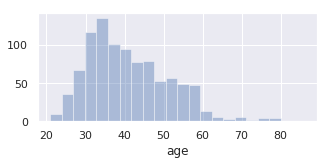

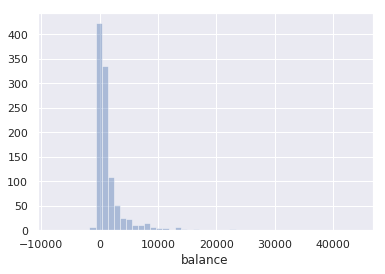

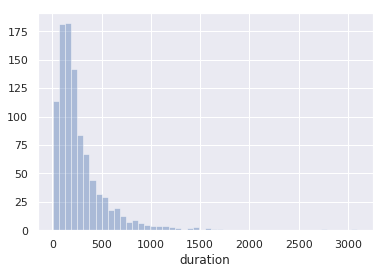

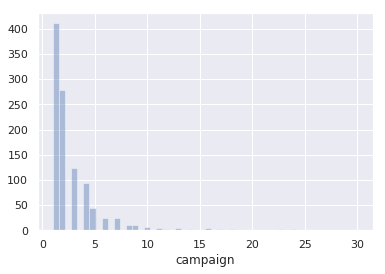

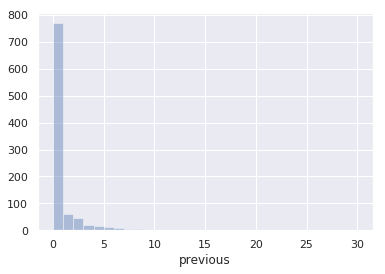

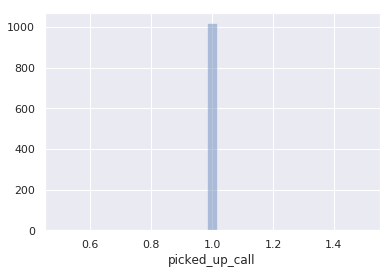

In [0]:
filas=bank_df.count()
filas
plt.figure(figsize=(5,2))
for col in bank_int:
 sample_data = bank_df.select(col).sample(False, fraction=1000/filas).toPandas()
 sns.distplot(sample_data[col], kde=False)
 plt.show()


Se comrprueba que la variable "picked_up_call" todos los valores se concentran en una columna y no aporta al modelo.

**Matriz de correlación**

In [0]:
corr_matrix = Statistics.corr(bank_df.select(bank_int).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')


corr_matrix

array([[ 1.        ,  0.09778274, -0.00464843,  0.00476031,  0.00128832,
        -0.01104484],
       [ 0.09778274,  1.        ,  0.02156038, -0.01457828,  0.01667364,
        -0.00469744],
       [-0.00464843,  0.02156038,  1.        , -0.0845695 ,  0.00120306,
        -0.01287982],
       [ 0.00476031, -0.01457828, -0.0845695 ,  1.        , -0.03285529,
        -0.00237398],
       [ 0.00128832,  0.01667364,  0.00120306, -0.03285529,  1.        ,
        -0.01445159],
       [-0.01104484, -0.00469744, -0.01287982, -0.00237398, -0.01445159,
         1.        ]])

Transforma la matriz en un DataFrame de pandas


In [0]:
corrpddf = pd.DataFrame(corr_matrix, columns=bank_int, index=bank_int)
corrpddf


,age,balance,duration,campaign,previous,picked_up_call
age,1.000000,0.097783,-0.004648,0.004760,0.001288,-0.011045
balance,0.097783,1.000000,0.021560,-0.014578,0.016674,-0.004697
duration,-0.004648,0.021560,1.000000,-0.084570,0.001203,-0.012880
campaign,0.004760,-0.014578,-0.084570,1.000000,-0.032855,-0.002374
previous,0.001288,0.016674,0.001203,-0.032855,1.000000,-0.014452
picked_up_call,-0.011045,-0.004697,-0.012880,-0.002374,-0.014452,1.000000


Elimina triangulo superior y representa

In [0]:
%matplotlib inline
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False, False,  True,  True],
       [False, False, False, False, False,  True]])

In [0]:
corrpddf=corrpddf.mask(mask)
corrpddf

,age,balance,duration,campaign,previous,picked_up_call
age,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.097783,NaN,NaN,NaN,NaN,NaN
duration,-0.004648,0.021560,NaN,NaN,NaN,NaN
campaign,0.004760,-0.014578,-0.084570,NaN,NaN,NaN
previous,0.001288,0.016674,0.001203,-0.032855,NaN,NaN
picked_up_call,-0.011045,-0.004697,-0.012880,-0.002374,-0.014452,NaN


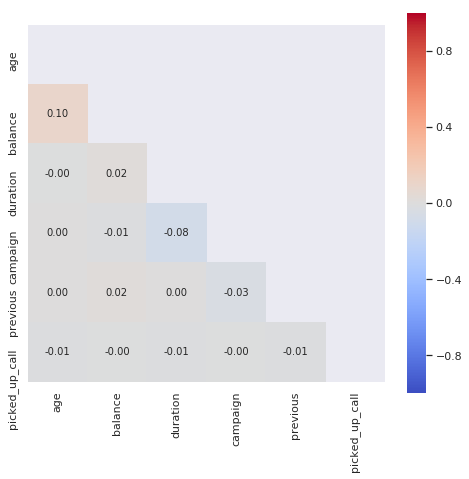

In [0]:
plt.figure(figsize=(8,7))
sns.heatmap(corrpddf, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

Obtener columnas altamente correlacionadas

In [0]:
umbral = 0.01
for col in corrpddf.columns:
    for fila in corrpddf.columns:
        corrseldf = corrpddf.loc[fila][col]
        if (corrseldf > umbral and corrseldf < 1.0) or (corrseldf < -1*umbral and corrseldf > -1.0):
            print (fila, " - " , col, " : " ,corrseldf)    

balance  -  age  :  0.09778273937135205
picked_up_call  -  age  :  -0.011044844680030886
duration  -  balance  :  0.02156038049466946
campaign  -  balance  :  -0.014578278850767592
previous  -  balance  :  0.016673636728358268
campaign  -  duration  :  -0.08456950273006515
picked_up_call  -  duration  :  -0.012879816843348522
previous  -  campaign  :  -0.032855289678279984
picked_up_call  -  previous  :  -0.0144515866409351


Vemos que no hay  ninguna variable altamente correlacionada, nosotros hemos realizado nuestro estudio las siguientes variables 


'age', 'balance', 'duration', 'campaign', 'previous', 'picked_up_call'

Estudio de **análisis cualitativas**

Viendo los valores que han tomado las variables categoricas, vamos a intentar unificar algunos de ellos

Análisis de la **edad**

In [0]:
bank_df.groupby("y_bool").agg(F.count("age"), F.mean("age")).show()


+------+----------+------------------+
|y_bool|count(age)|          avg(age)|
+------+----------+------------------+
|  true|      5289|41.670069956513515|
| false|     39922| 40.83898602274435|
+------+----------+------------------+



Conclusión 1
Según lo que nos muestra esta tabla, la contratación del deposíto no está relacionada con la edad del cliente, ya que la media de clientes que han contratado un deposito en igual a la que no ha contratado 

Analisis de **trabajo**


In [0]:
bank_df.groupby("job", "y_bool").agg(F.count("age").alias("count")).sort("job").show(50)

+-------------+------+-----+
|          job|y_bool|count|
+-------------+------+-----+
|       admin.| false| 4540|
|       admin.|  true|  631|
|  blue-collar| false| 9024|
|  blue-collar|  true|  708|
| entrepreneur|  true|  123|
| entrepreneur| false| 1364|
|    housemaid| false| 1131|
|    housemaid|  true|  109|
|   management|  true| 1301|
|   management| false| 8157|
|      retired|  true|  516|
|      retired| false| 1748|
|self-employed| false| 1392|
|self-employed|  true|  187|
|     services|  true|  369|
|     services| false| 3785|
|      student|  true|  269|
|      student| false|  669|
|   technician|  true|  840|
|   technician| false| 6757|
|   unemployed| false| 1101|
|   unemployed|  true|  202|
|      unknown| false|  254|
|      unknown|  true|   34|
+-------------+------+-----+



Vamos a seleccionar  aquellos clientes que tienen contratado el depósito y por otro lado los clientes que no tienen contratado el depósito

In [0]:
bank_ytrue_df = bank_df.filter(F.col("y_bool")== True)

In [0]:
bank_yfalse_df = bank_df.filter(F.col("y_bool")== False)

Lo convertimos a pandas

In [0]:
bank_pd = bank_ytrue_df.toPandas()

In [0]:
bank_falsepd = bank_yfalse_df.toPandas()

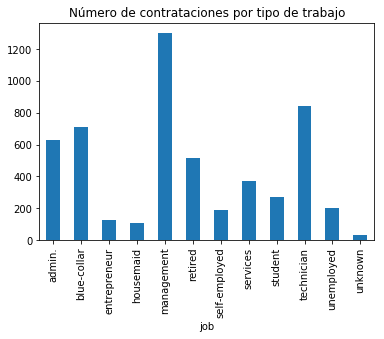

In [51]:
bank_pd.groupby("job").agg({"job":"count"}).plot.bar(title="Número de contrataciones por tipo de trabajo", legend=False)

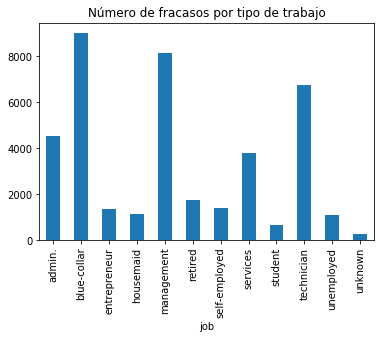

In [52]:
bank_falsepd.groupby("job").agg({"job":"count"}).plot.bar(title="Número de fracasos por tipo de trabajo", legend=False)

Conclusión 2: Los depósitos mayormente contratados son por empresarios, pero los que no contratan también son mayoritarios los empresarios y los blue-collar, por lo que,  no vemos relación en el tipo de trabajo con los depositos.



Análisis de **estudios**

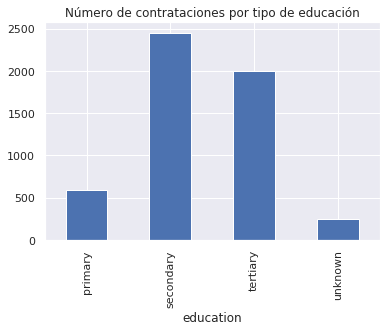

In [0]:
bank_pd.groupby("education").agg({"education":"count"}).plot.bar(title="Número de contrataciones por tipo de educación", legend=False)

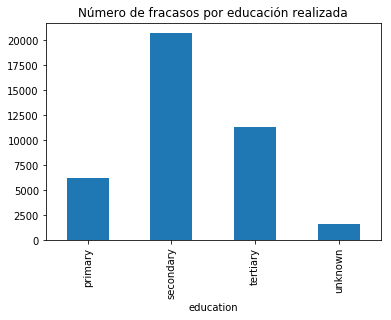

In [53]:
bank_falsepd.groupby("education").agg({"education":"count"}).plot.bar(title="Número de fracasos por educación realizada", legend=False)

Conclusión 3: Vemos que los que completaron los estudios de secundaria son los que mas  contrataron depósitos, pero entre los que no contratan también son mayoritarios los que completaron los estudios de secundaria, por lo que, no vemos relación en el tipo de estudio con los depositos.

Análisis por **estado civil**

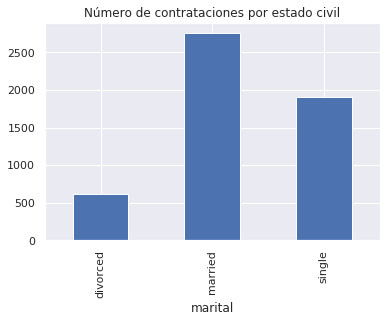

In [0]:
bank_pd.groupby("marital").agg({"marital":"count"}).plot.bar(title="Número de contrataciones por estado civil", legend=False)

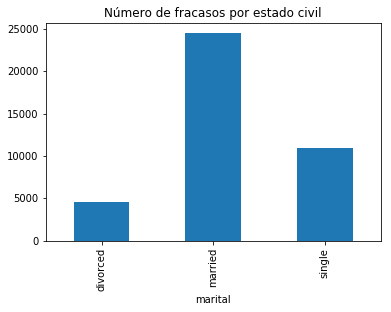

In [54]:
bank_falsepd.groupby("marital").agg({"marital":"count"}).plot.bar(title="Número de fracasos por estado civil", legend=False)

Conclusión 4: Vemos que los casados son los que mas contrataron depósitos, pero entre los que no contratan también son mayoritarios los casados, por lo que, no vemos relación en el estado civil con los depositos.

Análisis por tenencia de **préstamo hipotecario**

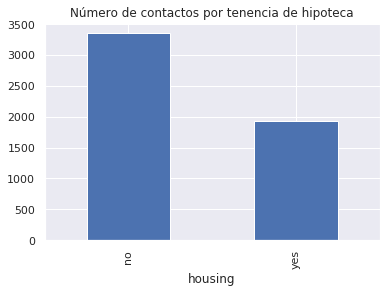

In [0]:
bank_pd.groupby("housing").agg({"housing":"count"}).plot.bar(title="Número de contrataciones por tenencia de hipoteca", legend=False)

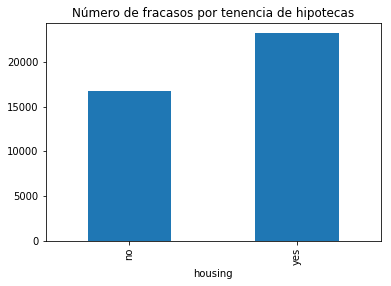

In [55]:
bank_falsepd.groupby("housing").agg({"housing":"count"}).plot.bar(title="Número de fracasos por tenencia de hipotecas", legend=False)

Conclusión 5: Los que contratan, no tienen hipotecas

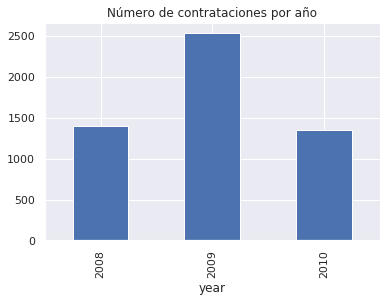

In [0]:
bank_pd.groupby("year").agg({"year":"count"}).plot.bar(title="Número de contrataciones por año", legend=False)

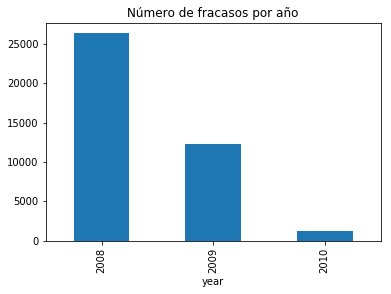

In [56]:
bank_falsepd.groupby("year").agg({"year":"count"}).plot.bar(title="Número de fracasos por año", legend=False)

Conclusión 6: EL año de mayor exito de la campaña fue el 2009 y el mayor fracaso en el 2008, pero en porcentaje de exito vemos que el 2010 fue el más exitoso.

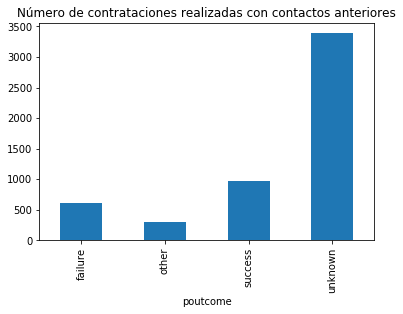

In [77]:
bank_pd.groupby("poutcome").agg({"poutcome":"count"}).plot.bar(title="Número de contrataciones realizadas con contactos anteriores", legend=False)

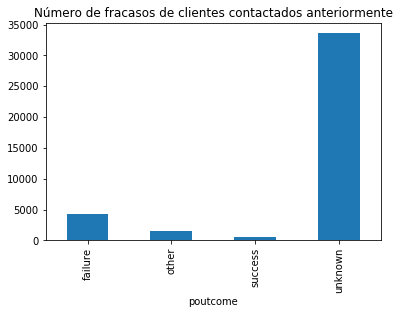

In [57]:
bank_falsepd.groupby("poutcome").agg({"poutcome":"count"}).plot.bar(title="Número de fracasos de clientes contactados anteriormente", legend=False)

In [0]:
bank_pd_total = bank_df.toPandas()

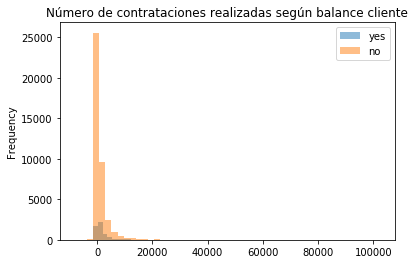

In [68]:
bank_pd["balance"].plot.hist(title="Número de contrataciones realizadas según balance cliente", bins=50,legend=False, alpha=0.5, label='yes')
bank_falsepd["balance"].plot.hist(title="Número de contrataciones realizadas según balance cliente", bins=50,legend=False, alpha=0.5, label='no')
plt.legend()
plt.show()

In [69]:
results = bank_ytrue_df.select(operations).first()

for col in bank_int:
    
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    
    print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))

age: avg=41.67, std=13.5, min=18, max=95
balance: avg=1804.27, std=3501.1, min=-3058, max=81204
duration: avg=537.29, std=392.53, min=8, max=3881
campaign: avg=2.14, std=1.92, min=1, max=32
previous: avg=1.17, std=2.55, min=0, max=58
picked_up_call: avg=1.0, std=0.01, min=0, max=1


In [70]:
results = bank_yfalse_df.select(operations).first()

for col in bank_int:
    
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    
    print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))

age: avg=40.84, std=10.17, min=18, max=95
balance: avg=1303.71, std=2974.2, min=-8019, max=102127
duration: avg=221.18, std=207.38, min=0, max=4918
campaign: avg=2.85, std=3.21, min=1, max=63
previous: avg=0.5, std=2.26, min=0, max=275
picked_up_call: avg=1.0, std=0.01, min=0, max=1


In [0]:
q2 = bank_df.approxQuantile('balance',[0.5],0) #calculo de la mediana total

In [72]:
q2

[448.0]

In [0]:
q2 = bank_ytrue_df.approxQuantile('balance',[0.5],0) #calculo de la mediana de los que contratan el deposito

In [74]:
q2

[733.0]

In [0]:
q2 = bank_yfalse_df.approxQuantile('balance',[0.5],0) #calculo de la mediana de los que no han contratado el deposito

In [76]:
q2

[417.0]